# Explore here

It's recommended to use this notebook for exploration purposes.

/tmp/ipykernel_45773/3642894207.py:28: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(untransformed_html)[0]  # only care about first table for now


     ID                 SONG                         ARTIST  STREAMS  \
0     1    "Blinding Lights"                     The Weeknd    4.791   
1     2       "Shape of You"                     Ed Sheeran    4.310   
2     3  "Someone You Loved"                  Lewis Capaldi    3.865   
3     4            "Starboy"       The Weeknd and Daft Punk    3.838   
4     5          "As It Was"                   Harry Styles    3.832   
..  ...                  ...                            ...      ...   
95   96       "Stay With Me"                      Sam Smith    2.274   
96   97             "Havana"  Camila Cabello and Young Thug    2.261   
97   98   "Someone Like You"                          Adele    2.260   
98   99      "All the Stars"         Kendrick Lamar and SZA    2.247   
99  100           "Memories"                       Maroon 5    2.238   

         RELEASE_DATE  
0    29 November 2019  
1      6 January 2017  
2     8 November 2018  
3   21 September 2016  
4        1 Apri

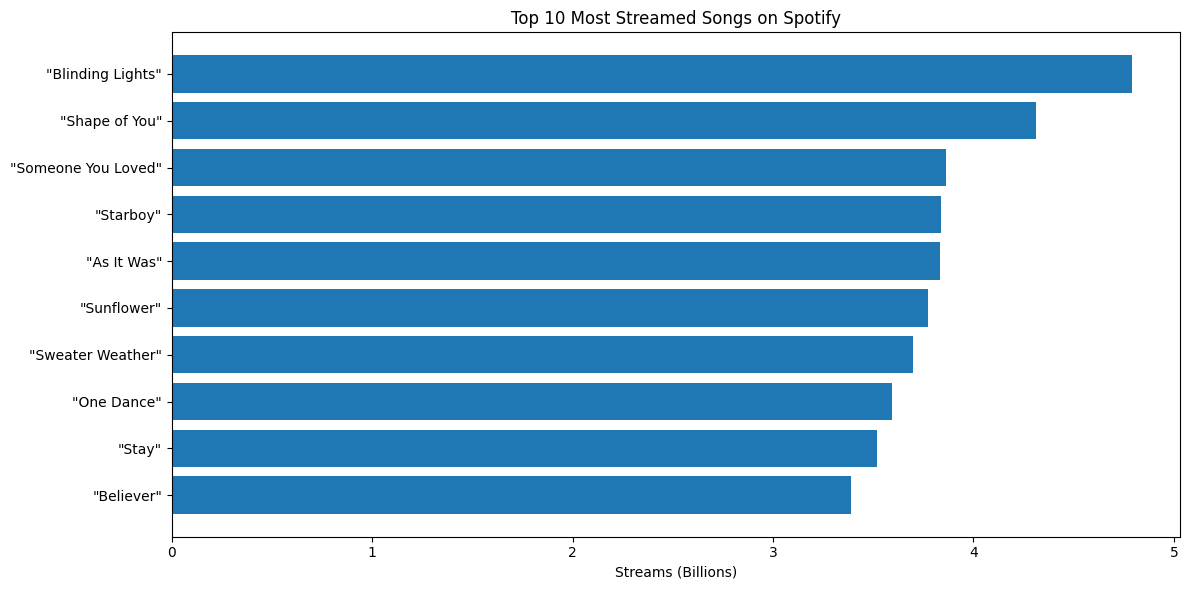

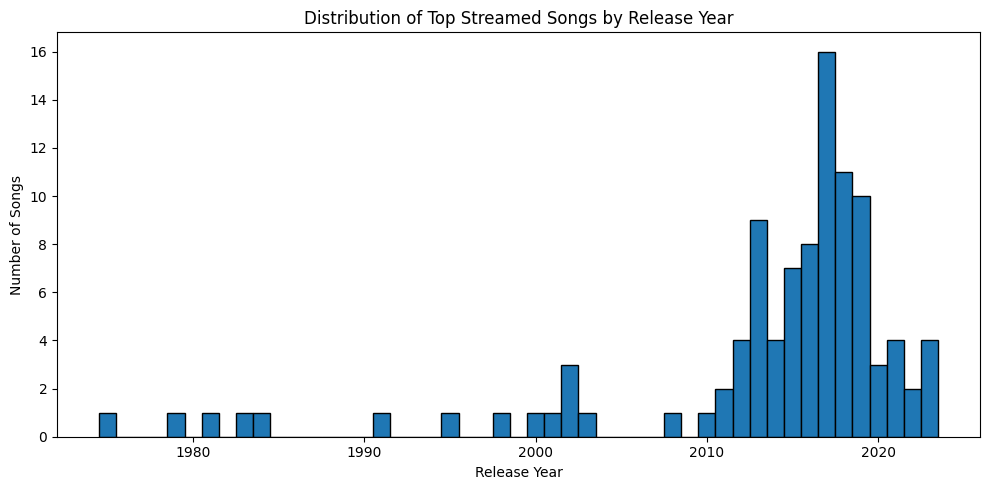

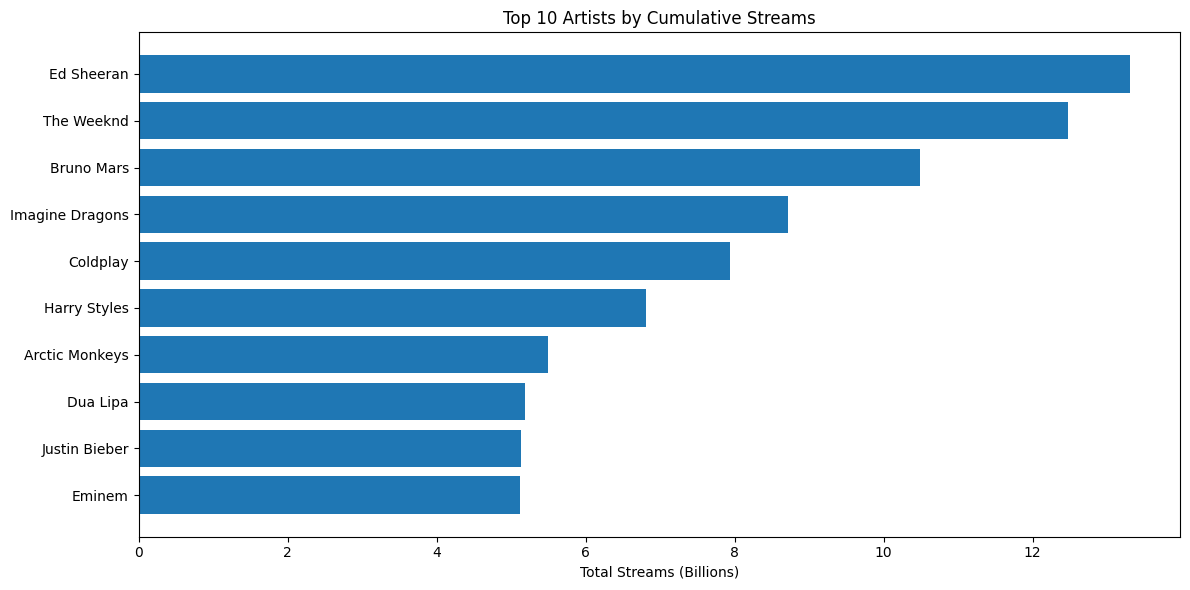

In [3]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
from sqlite3 import Connection
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import DataFrame

DATABASE_FILE = "temp.db"

def download_html(site_to_get: str) -> str:
    resource_url = site_to_get
    # Request to download the file from the Internet
    response = requests.get(resource_url, time.sleep(10))

    # If the request has been executed correctly (code 200), then the HTML content of the page has been downloaded
    # if response:
    #    # We transform the flat HTML into real HTML (structured and nested, tree-like)
    #    soup = BeautifulSoup(response.text, features="lxml")
    #    soup
    return response.text  # seems overkill to use beautifulsoup for this


def transform_html(untransformed_html) -> pd.DataFrame:
    table = pd.read_html(untransformed_html)[0]  # only care about first table for now
    return table


def process_dataframe(unprocessed_df): 
    # last column in table is Wikipedia's citation links, not useful to us, can drop it
    unprocessed_df = unprocessed_df.drop(columns=["Ref."])

    # last row in table is a disclaimer about how recent the data is,
    # not relevant to what we're doing, so just drop that last row
    unprocessed_df = unprocessed_df.drop(unprocessed_df.index[-1])
    # Map DataFrame columns to SQLite table's columns
    unprocessed_df.columns = [col.strip() for col in unprocessed_df.columns]
    df_clean = unprocessed_df.rename(
        columns={
            "Rank": "ID",
            "Song": "SONG",
            "Artist(s)": "ARTIST",
            "Streams (billions)": "STREAMS",
            "Release date": "RELEASE_DATE",
        }
    )

    df_clean["STREAMS"] = pd.to_numeric(
        df_clean["STREAMS"], errors="coerce"
    )  # Handle conversion
    df_clean = df_clean[
        ["ID", "SONG", "ARTIST", "STREAMS", "RELEASE_DATE"]
    ]  # Enforce order
    print(f"{df_clean}")
    return df_clean


def connect_to_sqlite() -> Connection:
    # Connect to the database or create it if it doesn't exist
    con = sqlite3.connect(DATABASE_FILE)
    con.execute("""DROP TABLE IF EXISTS MOSTSTREAMEDSONGS""")
    con.execute("""CREATE TABLE MOSTSTREAMEDSONGS (
    ID INT PRIMARY KEY     NOT NULL,
    SONG           TEXT    NOT NULL,
    ARTIST         TEXT    NOT NULL,
    STREAMS        REAL    NOT NULL,
    RELEASE_DATE   TEXT
    )""")
    return con


def store_in_sqlite(con: Connection, df_to_store: DataFrame):
    con.executemany(
        "INSERT INTO MOSTSTREAMEDSONGS (ID, SONG, ARTIST, STREAMS, RELEASE_DATE) VALUES (?, ?, ?, ?, ?)",
        df_to_store.itertuples(index=False, name=None),
    )
    con.commit()


def visualize_data(db_path: str = DATABASE_FILE):
    con = sqlite3.connect(db_path)

    # Load data from SQLite
    df = pd.read_sql_query("SELECT * FROM MOSTSTREAMEDSONGS", con)
    con.close()

    # Convert release date to datetime where possible
    df['RELEASE_DATE'] = pd.to_datetime(df['RELEASE_DATE'], errors='coerce')
    df['RELEASE_YEAR'] = df['RELEASE_DATE'].dt.year

    # Sort and take top 10 songs by streams
    top10 = df.sort_values('STREAMS', ascending=False).head(10)

    # Plot 1: Top 10 streamed songs
    plt.figure(figsize=(12, 6))
    plt.barh(top10['SONG'][::-1], top10['STREAMS'][::-1])
    plt.xlabel("Streams (Billions)")
    plt.title("Top 10 Most Streamed Songs on Spotify")
    plt.tight_layout()
    plt.show()

    # Plot 2: Histogram of release years
    plt.figure(figsize=(10, 5))
    df_with_years = df.dropna(subset=['RELEASE_YEAR'])
    plt.hist(df_with_years['RELEASE_YEAR'], bins=range(df_with_years['RELEASE_YEAR'].min(), df_with_years['RELEASE_YEAR'].max() + 1), align='left', edgecolor='black')
    plt.xlabel("Release Year")
    plt.ylabel("Number of Songs")
    plt.title("Distribution of Top Streamed Songs by Release Year")
    plt.tight_layout()
    plt.show()


    # Plot 3: Top 10 artists by total streams
    artist_streams = df.groupby('ARTIST')['STREAMS'].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(12, 6))
    plt.barh(artist_streams.index[::-1], artist_streams.values[::-1])
    plt.xlabel("Total Streams (Billions)")
    plt.title("Top 10 Artists by Cumulative Streams")
    plt.tight_layout()
    plt.show()


site_downloaded = download_html(
    "https://en.wikipedia.org/wiki/List_of_Spotify_streaming_records"
)
table_to_process = transform_html(site_downloaded)
processed_table = process_dataframe(table_to_process)
sql_connection = connect_to_sqlite()
store_in_sqlite(sql_connection, processed_table)
visualize_data()
